In [34]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, plot_roc_curve

import matplotlib.pyplot as plt
sns.set()

import datetime
import os
import gc


In [35]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [36]:
IMG_SIZE = 256
def process_image(img_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Load the tabular data

In [37]:
df = pd.read_csv('data/train.csv')

In [38]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [39]:
df.rename(columns={'age_approx':'age', 'anatom_site_general_challenge':'anatom'}, inplace = True)
df.dropna(axis=0, inplace = True)
df.isnull().sum()

image_name          0
patient_id          0
sex                 0
age                 0
anatom              0
diagnosis           0
benign_malignant    0
target              0
dtype: int64

In [40]:
X = df.drop(['target', 'benign_malignant', 'patient_id'], axis = 1)
X.set_index('image_name', inplace=True)
targets = df.target
X.head()

,sex,age,anatom,diagnosis
image_name,,,,
ISIC_2637011,male,45.0,head/neck,unknown
ISIC_0015719,female,45.0,upper extremity,unknown
ISIC_0052212,female,50.0,lower extremity,nevus
ISIC_0068279,female,45.0,head/neck,unknown
ISIC_0074268,female,55.0,upper extremity,unknown


## Visualizing the data

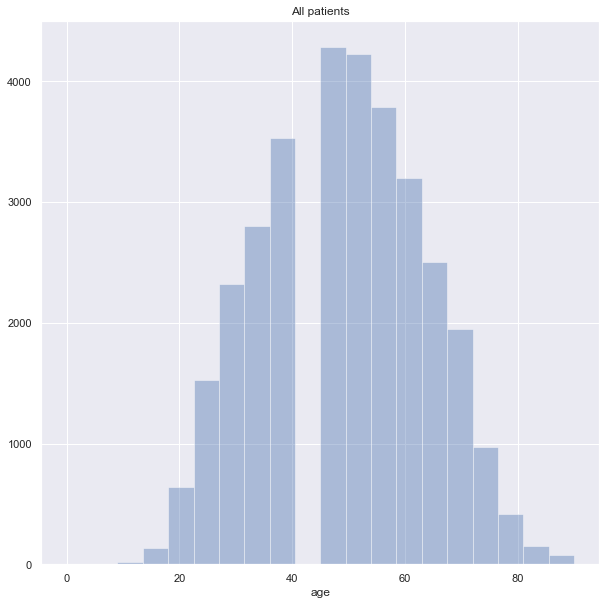

In [41]:
plt.figure(figsize=(10,10))
sns.distplot(df.age,bins=20,kde=False);
plt.title('All patients');

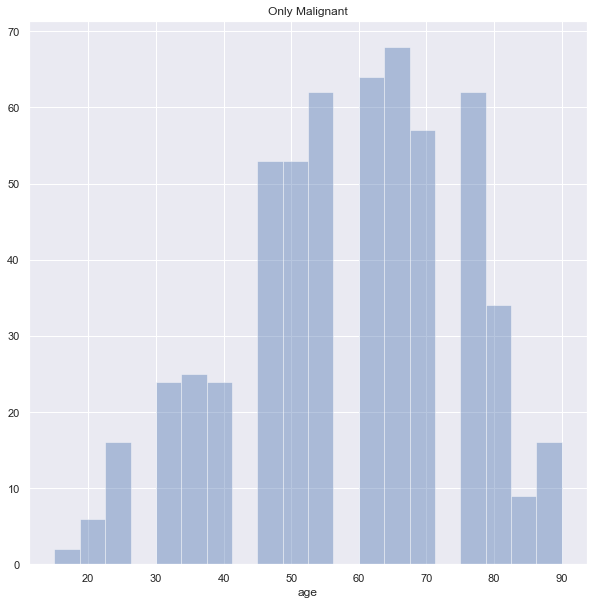

In [42]:
plt.figure(figsize=(10,10))
sns.distplot(df.age[df.target == 1],bins=20, kde=False);
plt.title('Only Malignant');

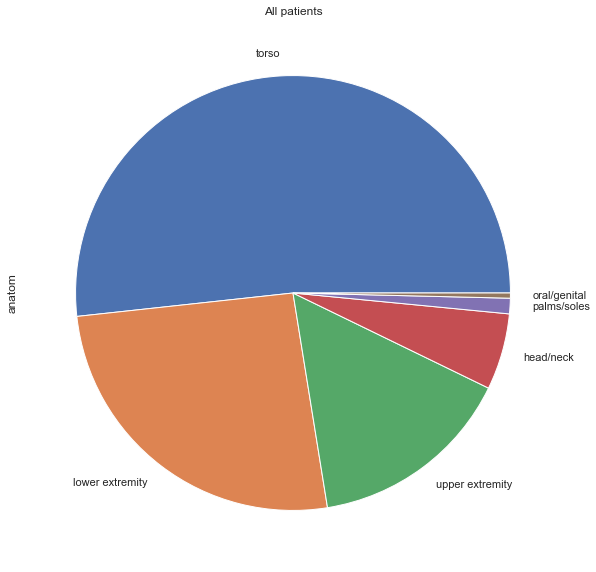

In [43]:
df['anatom'].value_counts().plot.pie(figsize=(20, 10));
plt.title('All patients');

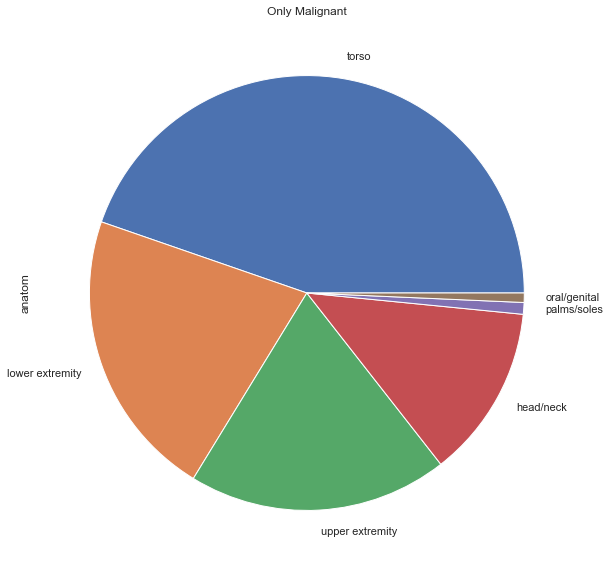

In [44]:
df.anatom[df.target==1].value_counts().plot.pie(figsize=(20, 10));
plt.title('Only Malignant');

In [45]:
pd.crosstab(targets,df.sex)

sex,female,male
target,,
0,15526,16430
1,217,358


In [46]:
df_group=df.groupby('anatom').mean().mul(100)

In [47]:
df_group.drop('age', axis=1, inplace = True)
df_group.rename(columns={'target': 'Percent_Melignant'})

,Percent_Melignant
anatom,
head/neck,4.010840
lower extremity,1.476366
oral/genital,3.225806
palms/soles,1.333333
torso,1.527489
upper extremity,2.236550


In [48]:
# Calculating the weights for the unbalanced datset
Total_num = len(targets)
Num_mlg = np.count_nonzero(targets)
Num_bng = Total_num-Num_mlg

Weight_bng = 1/Num_bng * Total_num/2
Weight_mlg = 1/Num_mlg * Total_num/2

class_weights = {0: Weight_bng, 1: Weight_mlg}

In [49]:
# Create dummy variables for input of the model
dummies = [pd.get_dummies(X.sex), pd.get_dummies(X.anatom)]
dummies = pd.concat(dummies, axis = 1)
X = pd.concat([X, dummies], axis = 1)
X.drop(['sex', 'anatom', 'diagnosis'], axis = 1, inplace = True)
X.age = X.age/np.max(X.age)
#targets = pd.get_dummies(targets)

## Split the data to training and validation sets

In [50]:
x_train, x_val, y_train, y_val = train_test_split(X, targets, test_size = 0.2, random_state = 42)

## Test the initial results of different models

In [51]:
KNN = KNeighborsClassifier()
np.random.seed(42)
KNN.fit(x_train,y_train)
y_pred = KNN.predict(x_val)
print('KNeighborsClassifier Score: {}\n'.format(KNN.score(x_val,y_val)))
print('Confusion Matrix: \n\n{}'.format(confusion_matrix(y_val,y_pred)))

KNeighborsClassifier Score: 0.9843245735361917

Confusion Matrix: 

[[6405    0]
 [ 102    0]]


In [52]:
LR = LogisticRegression(class_weight = class_weights)
LR.fit(x_train,y_train)
y_pred = LR.predict(x_val)
print('LogisticRegression Score: {}\n'.format(LR.score(x_val,y_val)))
print('Confusion Matrix: \n\n{}'.format(confusion_matrix(y_val,y_pred)))

LogisticRegression Score: 0.6342400491778085

Confusion Matrix: 

[[4062 2343]
 [  37   65]]


In [53]:
RF = RandomForestClassifier(class_weight = class_weights)
RF.fit(x_train,y_train)
y_pred = RF.predict(x_val)
print('Random_Forest Score: {}\n'.format(RF.score(x_val,y_val)))
print('Confusion Matrix: \n\n{}'.format(confusion_matrix(y_val,y_pred)))

Random_Forest Score: 0.6718918088212694

Confusion Matrix: 

[[4319 2086]
 [  49   53]]


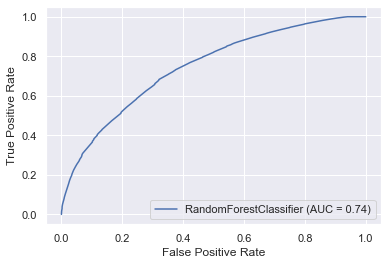

In [54]:
## Random Forest seems to be more successful

plot_roc_curve(RF, x_train,y_train);

## Find the optimal hyperparameters for RandomForest

In [26]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(1, 100, 5),
           "max_depth": [None, 3, 25, 30],
           "min_samples_split": np.arange(10, 40, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}
rs_model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,class_weight= class_weights),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Wall time: 27.9 s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   27.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight={0: 0.508996745525097,
                                                                  1: 28.287826086956525},
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples

In [27]:
rs_model.best_params_

{'n_estimators': 46,
 'min_samples_split': 22,
 'min_samples_leaf': 17,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': None}

## Comparing the result with initial parameters and with optimized hyperparameters

In [28]:
##Base model
y_pred = RF.predict(x_val)
print('Random_Forest Score: {}\n'.format(RF.score(x_val,y_val)))
confusion_matrix(y_val,y_pred)

Random_Forest Score: 0.6718918088212694



array([[4319, 2086],
       [  49,   53]], dtype=int64)

In [29]:
np.random.seed(42)
Opt_RF = RandomForestClassifier(n_estimators= 70,
                                min_samples_split= 2,
                                min_samples_leaf= 5,
                                max_features= 'auto',
                                max_depth= 5,
                                class_weight= class_weights)
Opt_RF.fit(x_train,y_train);
y_pred = Opt_RF.predict(x_val)
print('Random_Forest Score: {}\n'.format(Opt_RF.score(x_val,y_val)))
confusion_matrix(y_val,y_pred)

Random_Forest Score: 0.7233748271092669



array([[4654, 1751],
       [  49,   53]], dtype=int64)

In [30]:
np.random.seed(42)
Opt_RF = RandomForestClassifier(n_estimators= 10,
                                min_samples_split= 18,
                                min_samples_leaf= 1,
                                max_samples= 10000,
                                max_features= 'auto',
                                max_depth= None,
                                class_weight= class_weights)
Opt_RF.fit(x_train,y_train);
y_pred = Opt_RF.predict(x_val)
print('Random_Forest Score: {}\n'.format(Opt_RF.score(x_val,y_val)))
confusion_matrix(y_val,y_pred)

Random_Forest Score: 0.7476563700630091



array([[4821, 1584],
       [  58,   44]], dtype=int64)

## Save the results

In [35]:
import joblib

def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  joblib.dump(Opt_RF,model_path)
  return model_path

In [37]:
save_model(Opt_RF, suffix='RandomForest')

Saving model to: models\20200704165437-RandomForest.h5...


'models\\20200704165437-RandomForest.h5'